<a href="https://colab.research.google.com/github/mekhi-woods/HiloCATsSN1991bg/blob/master/amadeus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [731]:
# """ START UP """
# import os
# import shutil
# if os.path.exists('/content/HiloCATsSN1991bg') == True:
#     shutil.rmtree('/content/HiloCATsSN1991bg')
#     !git clone https://github.com/mekhi-woods/HiloCATsSN1991bg.git
# else:
#     !git clone https://github.com/mekhi-woods/HiloCATsSN1991bg.git

# !pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple snpy
# !pip install requests
# !pip install sncosmo
# !pip install iminuit
# !pip install pandas
# !pip install astro_ghost

In [732]:
""" IMPORTS """
import os
import glob
import json
import snpy
import shutil
import sncosmo
import requests
import numpy as np
import urllib.request
import time as systime
import matplotlib.pyplot as plt
from zipfile import ZipFile
from requests.auth import HTTPBasicAuth
from HiloCATsSN1991bg.scripts import tns_redshifts
from astropy.table import QTable, Table, Column
from astropy import units as u

import astro_ghost
from astro_ghost.ghostHelperFunctions import getTransientHosts
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord


In [733]:
""" GLOBALS """
# TNS CREDINTIALS
tns_bot_id, tns_bot_name, tns_bot_api_key = '73181', 'YSE_Bot1', '0d771345fa6b876a5bb99cd5042ab8b5ae91fc67'

# PATHS
ROOT_PATH = '/content/HiloCATsSN1991bg/'
SNPY_ROOT = ROOT_PATH+'snpy/'
PLOTS_ROOT = ROOT_PATH+'plots/'
TEST_ROOT = ROOT_PATH+'test/'

SNPY_BURNS = SNPY_ROOT+'burns/'
SNPY_BURNS_PLOTS = SNPY_BURNS+'plots/'
BURNS_SAVE_TXT = SNPY_BURNS+'burns_saved.txt'

DATA_ATLAS = ROOT_PATH+'data/ATLAS/'
SNPY_ATLAS = SNPY_ROOT+'atlas/'
SNPY_ATLAS_PLOTS = SNPY_ATLAS+'plots/'
SNPY_ATLAS_ASCII = SNPY_ATLAS+'ascii/'
ATLAS_SAVE_TXT = SNPY_ATLAS+'atlas_saved.txt'

DATA_ZTF = ROOT_PATH+'data/ZTF/'


PROB_CHILD_TXT = ROOT_PATH+'problem_children.txt'
TNS_KEY_TXT = ROOT_PATH+'TNS_key.txt'


In [734]:
""" GENERAL """
def recover_dir():
    directories = [ROOT_PATH,
                   DATA_ATLAS,
                   SNPY_ROOT, SNPY_BURNS, SNPY_BURNS_PLOTS,
                   SNPY_ATLAS, SNPY_ATLAS_PLOTS, SNPY_ATLAS_ASCII,
                   PLOTS_ROOT, TEST_ROOT]
    files = [PROB_CHILD_TXT, TNS_KEY_TXT,
             BURNS_SAVE_TXT, ATLAS_SAVE_TXT]
    for dir in directories:
        if os.path.exists(dir) == False:
            os.mkdir(dir)
    for n_file in files:
        if os.path.exists(n_file) == False:
            with open(n_file, 'w') as f:
                pass
    return

def TNS_details(ra, dec):
    # Code from David
    headers = tns_redshifts.build_tns_header(tns_bot_id, tns_bot_name)
    tns_api_url = f"https://www.wis-tns.org/api/get"

    # get the API URLs
    search_tns_url = tns_redshifts.build_tns_url(tns_api_url, mode="search")
    get_tns_url = tns_redshifts.build_tns_url(tns_api_url, mode="get")

    search_data = tns_redshifts.build_tns_search_query_data(tns_bot_api_key, ra, dec)
    transients = tns_redshifts.rate_limit_query_tns(search_data, headers, search_tns_url)

    get_data = tns_redshifts.build_tns_get_query_data(tns_bot_api_key, transients[0])
    transient_detail = tns_redshifts.rate_limit_query_tns(get_data, headers, get_tns_url)

    return transient_detail

def snpy_fit(path, objname, save_loc, plot_save_loc, fit_filters=None, skip_problems=False, use_saved=False, snpy_plots=True):
    problem_children = handle_problem_children(state='READ') # Open problem children

    if skip_problems and (objname in problem_children):
        return None
    else:
        try:
            if use_saved and os.path.exists(save_loc+objname+'_EBV_model2.snpy'):
                n_s = snpy.get_sn(save_loc+objname+'_EBV_model2.snpy')
            else:
                n_s = snpy.get_sn(path)
                n_s.choose_model('EBV_model2', stype='st')
                n_s.set_restbands() # Auto pick appropriate rest-bands

                # Sort out empty filters & get start and end time
                mjds, mjde = [], []
                filter_wheel = []
                for filter in list(n_s.data.keys()):
                    if len(n_s.data[filter].MJD) <= 3:
                        print('\t', objname, 'has too few points in', filter, 'filter')
                        continue
                    mjds.append(min(n_s.data[filter].MJD))
                    mjde.append(max(n_s.data[filter].MJD))
                    filter_wheel.append(filter)
                print('\t', filter_wheel)

                n_s.fit(bands=filter_wheel, dokcorr=True, k_stretch=False, reset_kcorrs=True, **{'mangle':1,'calibration':0})
                n_s.save(save_loc+objname+'_EBV_model2.snpy')

            if snpy_plots:
                n_s.plot(outfile=plot_save_loc+objname+'_snpyplots.png')
                plt.show()
        except Exception as error:
            problem_children = np.append(problem_children, objname)
            handle_problem_children(state='WRITE', problem_c=problem_children) # Commit problem children
            return error

    plt.close()
    return {'ra': n_s.ra, 'dec': n_s.decl, 'mu': n_s.get_distmod(), 'z': n_s.z, 'st': n_s.st, 'Tmax': n_s.Tmax, 'EBVHost': n_s.EBVhost, 'MJDs': min(mjds), 'MJDe': max(mjde)}

def snpy_fit_indv(path, fit_filters=None, show_plot=True):
    s = snpy.get_sn(path)
    s.choose_model('EBV_model2', stype='st')
    s.set_restbands() # Auto pick appropriate rest-bands
    s.fit(bands=fit_filters, dokcorr=True, k_stretch=False, reset_kcorrs=True, **{'mangle':1,'calibration':0})
    if show_plot:
        plt.show()
    else:
        plt.close()
    return {'mu': s.get_distmod(), 'z': s.z, 'st': s.st, 'Tmax': s.Tmax, 'EBVHost': s.EBVhost}, s

def snpy_fit_comprehensive(path, objname, save_loc, plot_save_loc, fit_filters=None, skip_problems=False, use_saved=False, snpy_plots=True):
    problem_children = handle_problem_children(state='READ') # Open problem children

    if skip_problems and (objname in problem_children):
        return None
    else:
        try:
            if use_saved and os.path.exists(save_loc+objname+'_EBV_model2.snpy'):
                n_s = snpy.get_sn(save_loc+objname+'_EBV_model2.snpy')
            else:
                n_s = snpy.get_sn(path)
                n_s.choose_model('EBV_model2', stype='st')
                n_s.set_restbands() # Auto pick appropriate rest-bands
                n_s.fit(bands=fit_filters, dokcorr=True, k_stretch=False, reset_kcorrs=True, **{'mangle':1,'calibration':0})
                n_s.save(save_loc+objname+'_EBV_model2.snpy')
            if snpy_plots:
                n_s.plot(outfile=plot_save_loc+objname+'_snpyplots.png')
                plt.show()
        except Exception as error:
            print(type(error))
            problem_children = np.append(problem_children, objname)
            handle_problem_children(state='WRITE', problem_c=problem_children) # Commit problem children
            return None

    plt.close()
    return {'mu': n_s.get_distmod(), 'z': n_s.z, 'st': n_s.st, 'Tmax': n_s.Tmax, 'EBVHost': n_s.EBVhost}

def snpy_test_fit(objname):
    path = '/content/HiloCATsSN1991bg/data/CSPdata/'+objname+'_snpy.txt'
    print(path)

    s = snpy.get_sn(path)
    s.choose_model('EBV_model2', stype='st')
    s.set_restbands() # Auto pick appropriate rest-bands

    min_pts = 3
    mjds, mjde = [], []
    filter_wheel = []
    for filter in list(s.data.keys()):
        print(filter, len(s.data[filter].MJD))
        if len(s.data[filter].MJD) <= min_pts:
            print('[!!!]\t', objname, 'has too few points in', filter, 'filter')
            continue
        mjds.append(min(s.data[filter].MJD))
        mjde.append(max(s.data[filter].MJD))
        filter_wheel.append(filter)
    print('MJD min:', min(mjds), '+/- 100 MJD', '\nMJD max:', max(mjde), '+/- 100 MJD')
    print('Viable filters:', filter_wheel)

    s.fit(bands=filter_wheel, dokcorr=True, k_stretch=False, reset_kcorrs=True)
    s.save(TEST_ROOT+'SN2004dt_EBV_model2.snpy')

    return s

def read_DR3(loc='/content/HiloCATsSN1991bg/DR3_fits.dat'):
    data = np.genfromtxt(loc, dtype=str, skip_header=1)
    dr3 = {}
    for n in range(len(data[:, 0])):
        dr3.update({data[:, 0][n]: {'st': float(data[:, 1][n]), 'e_st': float(data[:, 2][n]), 'z': float(data[:, 3][n]),
                           'Tmax': float(data[:, 5][n]), 'e_Tmax': float(data[:, 6][n]),
                           'EBVHost': float(data[:, 25][n]), 'e_EBVHost': float(data[:, 26][n])}})
    return dr3

def dict_unpacker(path, delimiter=', '):
    with open(path, 'r') as f:
        hdr = f.readline()[:-1].split(delimiter)

    data = np.genfromtxt(path, delimiter=delimiter, dtype=str, skip_header=1)
    temp_objs = {}
    for i in range(len(data[:, 0])):
        obj = data[:, 0][i]
        temp_objs.update({obj: {}})
        for j in range(len(hdr)):
            temp_objs[obj].update({hdr[j]: data[i, j]})
    return temp_objs

def dict_packer(data_dict, save_loc, delimiter=', '):
    catagories = list(data_dict[list(data_dict.keys())[0]].keys())
    with open(save_loc, 'w') as f:
        f.write('objname')
        for category in catagories:
            f.write(delimiter+category)
        f.write('\n')
        for objname in data_dict:
            f.write(objname)
            for category in catagories:
                f.write(delimiter+str(data_dict[objname][category]))
            f.write('\n')
    return

def handle_problem_children(state, problem_c=None):
    if state == 'READ':
        # Read problem children
        problem_c = np.genfromtxt(PROB_CHILD_TXT, dtype=str)
        return problem_c
    elif state == 'WRITE':
        # Write problem children
        problem_c = np.unique(problem_c)
        with open(PROB_CHILD_TXT, 'w') as f:
            for c in problem_c:
                f.write(c+'\n')
        return None
    else:
        raise Exception("Invalid state: '"+state+"' [READ/WRITE]")



In [735]:
""" ATLAS """
def atlas_collection(quiet=False, check_data=True):
    api_token = '7f4e1dee8f52cf0c8cdaf55bf29d04bef4810fb4'

    if check_data and len(glob.glob(DATA_ATLAS+'*.txt')) > 1:
        print('ATLAS data already collected, passing step...')
        return
    else:
        print('No data detected, collecting ATLAS data...')
        if os.path.exists(DATA_ATLAS+'tmp.npz'):
            pickle = np.load(DATA_ATLAS+'tmp.npz', allow_pickle=True)
            data = pickle['data']

        data = requests.post('https://star.pst.qub.ac.uk/sne/atlas4/api/objectlist/',
                             headers={'Authorization': f'Token {api_token}'},
                             data={'objectlistid':2}).json()

        np.savez(DATA_ATLAS+'tmp.npz', data=data)

        count = 0
        for d in data:
            if d['observation_status'] is not None and d['observation_status'].startswith('SN Ia') and '91bg' in d['observation_status']:
                count += 1
                if not quiet:
                    print(d['atlas_designation'],d['observation_status'].replace(' ',''),d['ra'],d['dec'])


                ids = d['id']
                base_url = 'https://star.pst.qub.ac.uk/sne/atlas4/lightcurveforced/1161048951013729300/'
                new_url = base_url.replace('1161048951013729300/',str(ids))
                if not quiet:
                    print(new_url)

                idfile = DATA_ATLAS+'/' + str(ids)+'.txt'
                if os.path.exists(idfile):
                    continue
                urllib.request.urlretrieve(str(new_url), str(idfile))
                if not quiet:
                    print(idfile)

            if count > 300:
                break
    return

def atlas_tns_collection(files, quiet=False, check_data=False):
    for n in range(len(files)):
        ATLAS_name = files[n][len(DATA_ATLAS):-4]




    return

def atlas_processing(err_max=100, n_iter=10, sleep_t=5, use_TNS=False):
    print('Retrieving data from...', DATA_ATLAS)
    # Retrieve file paths
    files = glob.glob(DATA_ATLAS+'/*.txt')
    if n_iter != 0 and n_iter <= len(files):
        files = files[:n_iter]

    # TNS name sort
    atlas_tns_collection(files)


    objs = {}
    for n in range(len(files)):
        # Tracking/Cosmetics
        ATLAS_name = files[n][len(DATA_ATLAS):-4]
        tracker = '['+str(n+1)+'/'+str(len(files))+']' # Purely cosmetic
        print(tracker, '\n', '\t\tPulling', ATLAS_name, 'data...')

        # Reading file path
        try:
            data = np.genfromtxt(files[n], dtype=str, delimiter=',', skip_header=1)
            if len(data) == 0: # Handling empty files
                print('[!!!] \t\tFile '+ATLAS_name+' empty...skipping') # If empty, skips
                continue
        except:
            print('[!!!] \t\tUnknown error, skipping...') # Numpy was doing a weird thing, so crash hander until i figure it out
            continue
        ra, dec = np.average(data[:, 1].astype(float)), np.average(data[:, 2].astype(float)) # Recoring RA & DEC (average of columns)

        # Using TNS to get object name
        objname = ATLAS_name
        tns_sens = 0.1
        z = 0.00000000001
        if use_TNS:
            try:
                try:
                    print('\t\tChecking TNS key for', ATLAS_name, 'details...')
                    exsisting_tns = dict_unpacker(TNS_KEY_TXT)
                    for obj in exsisting_tns:
                        if abs(exsisting_tns[obj]['ra'] - ra) < tns_sens and abs(exsisting_tns[obj]['dec'] - dec) < tns_sens:
                            print('\t\tFound details for', ATLAS_name)
                            objname = obj
                            z = exsisting_tns[obj]['z']
                            break
                except:
                    print('\t\tRetrieving TNS data for...', ATLAS_name, '[sleeping for', sleep_t, 'seconds...]')
                    systime.sleep(sleep_t)
                    details = TNS_details(ra, dec)
                    objname = details['objname']
                    z = details['redshift']
                    exsisting_tns.update({objname: {'ra': ra, 'dec': dec, 'z': z}})
                    dict_packer(exsisting_tns, TNS_KEY_TXT)
            except:
                print('\t\tProblem retrieving TNS data, using ATLAS name...')

        mag = np.char.replace(data[:, 3], '>', '') # Removes greater than symbols
        dmag, filters, time, flux, dflux = data[:, 4], data[:, 6], data[:, 8], data[:, 24], data[:, 25] # Reads rest of categories
        objs.update({objname: {'ra': ra, 'dec': dec, 'z': z, 'time': time, 'flux': flux, 'dflux': dflux, 'mag': mag, 'dmag': dmag, 'filters': filters}})

        ## SLICING DATA
        # ------------------------------------------------------------------------------------------------------------------------------------------------------
        # Remove 'None' from categories
        mod_empty = np.array([])
        for cat in ['time', 'flux', 'dflux', 'mag', 'dmag', 'filters']:
            mod_empty = np.append(mod_empty, np.where(objs[objname][cat] == 'None')[0])
        mod_empty = np.unique(mod_empty).astype(int) # Remove dupes
        for cat in ['time', 'flux', 'dflux', 'mag', 'dmag', 'filters']:
            objs[objname][cat] = np.delete(objs[objname][cat], mod_empty)

        # Finds negative fluxes
        mod_positive = np.array([])
        for cat in ['time', 'flux', 'dflux', 'mag', 'dmag']:
            mod_positive = np.append(mod_positive, np.where(objs[objname][cat].astype(float) <= 0)[0])
        mod_positive = np.unique(mod_positive).astype(int) # Remove dupes
        for cat in ['time', 'flux', 'dflux', 'mag', 'dmag', 'filters']:
            objs[objname][cat] = np.delete(objs[objname][cat], mod_positive)

        # Find outliers beyond error limit
        mod_err = np.array([])
        for cat in ['dflux', 'dmag']:
            mod_err = np.append(mod_err, np.where(np.abs(objs[objname][cat].astype(float)) > err_max)[0])
        mod_err = np.unique(mod_err).astype(int) # Remove dupes
        for cat in ['time', 'flux', 'dflux', 'mag', 'dmag', 'filters']:
            objs[objname][cat] = np.delete(objs[objname][cat], mod_err)

        # Set everything as floats
        for cat in ['time', 'flux', 'dflux', 'mag', 'dmag']:
            objs[objname][cat] = objs[objname][cat].astype(float)

        # Seperate into orange & cyan channels
        for cat in ['time', 'flux', 'dflux', 'mag', 'dmag']:
            objs[objname].update({cat+'_o': objs[objname][cat][np.where(objs[objname]['filters'] == 'o')[0]]})
            objs[objname].update({cat+'_c': objs[objname][cat][np.where(objs[objname]['filters'] == 'c')[0]]})
        # ------------------------------------------------------------------------------------------------------------------------------------------------------

        print('\t\tRetrived:', objname+' |', 'ra:', ra, '\\', 'dec:', dec)
    print('[!!!]\t\tRetrieved & processed', len(objs), 'SNe from ATLAS!')
    return objs

def atlas_write_ASCII(atlas_objs, save_loc, quiet=True):
    print('Saving data to ASCII files for SNooPy...')
    for obj in atlas_objs:
        with open(save_loc+obj+'_snpy.txt', 'w') as f:
            # Line 1 -- Objname, Helio-Z, RA, Dec (Ex. SN1981D 0.005871 50.65992 -37.23272)
            f.write(str(obj)+' '+str(atlas_objs[obj]['z'])+' '+str(atlas_objs[obj]['ra'])+' '+str(atlas_objs[obj]['dec'])+'\n')

            # 'o'/'ATri'-filter photometry block -- Date (JD/MJD), mag, err (674.8593 12.94 0.11)
            f.write('filter ATri\n')
            for i in range(len(atlas_objs[obj]['time_o'])):
                f.write(str(atlas_objs[obj]['time_o'][i])+'\t'+str(atlas_objs[obj]['mag_o'][i])+'\t'+str(atlas_objs[obj]['dmag_o'][i])+'\n')

            # # 'c'/'ATgr'-filter photometry block
            f.write('filter ATgr\n')
            for i in range(len(atlas_objs[obj]['time_c'])):
                f.write(str(atlas_objs[obj]['time_c'][i])+'\t'+str(atlas_objs[obj]['mag_c'][i])+'\t'+str(atlas_objs[obj]['dmag_c'][i])+'\n')
    return

def atlas_snpy_fitting(n_iter=0, skip_problems=True, use_saved=True, snpy_plots=True, fit_filters=None):
    print('Fitting ATLAS data with SNooPy...')
    fit_args = {'skip_problems': skip_problems, 'use_saved': use_saved, 'snpy_plots': snpy_plots, 'fit_filters': fit_filters}
    print('Fitting arguments: ', fit_args)
    objpaths = glob.glob(SNPY_ATLAS_ASCII+'*')
    if n_iter != 0 and n_iter <= len(objpaths):
        objpaths = objpaths[:n_iter]

    objs = {}
    err_i = 0
    for n in range(len(objpaths)):
        tracker = '['+str(n+1)+'/'+str(len(objpaths))+']' # Purely cosmetic
        objname = objpaths[n][len(SNPY_ATLAS_ASCII):-9]
        print(tracker, objname)
        temp_dict = snpy_fit(objpaths[n], objname, save_loc=SNPY_ATLAS, plot_save_loc=SNPY_ATLAS_PLOTS, **fit_args)

        if type(temp_dict) == dict:
            print('\tResults: mu:', temp_dict['mu'], 'z =', temp_dict['z'], 'st =', temp_dict['st'], 'Tmax =', temp_dict['Tmax'], 'EBVHost =', temp_dict['EBVHost'])
            print('\tMJD min:', temp_dict['MJDs'], '+/- 100 MJD', '| MJD max:', temp_dict['MJDe'], '+/- 100 MJD\n')
            objs.update({objname: temp_dict})
        else:
            err_i += 1
            print('[!!!]\t', temp_dict, '\n')
    print('Finshed! Successfully fit', len(objpaths)-err_i, '/', len(objpaths), 'SNe from ATLAS! ['+str(round(((len(objpaths)-err_i) / len(objpaths))*100, 2))+'%]')

    # Save Data
    if len(objs) > 0:
        dict_packer(objs, ATLAS_SAVE_TXT, delimiter=', ') # Save data from fitting

    return

def atlas_plotting(choice):
    if 'reg_hist' in choice:
        print('Ploting Histogram of ATLAS SNooPy Fitting Parameters...')
        data = np.genfromtxt(SNPY_ATLAS+'atlas_saved.txt', dtype=str, delimiter=', ', skip_header=1)
        objnames, st, Tmax, EBVHost = data[:, 0], data[:, 3].astype(float), data[:, 4].astype(float), data[:, 5].astype(float)
        reg_params = [st, Tmax, EBVHost]
        bins_reg = [15, 20, 15]
        plot_title = 'ATLAS SNooPy Parameters'

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        titles = ['st', plot_title+'\nTmax', 'EBVhost']
        for i in range(len(titles)):
            ax[i].hist(reg_params[i], bins=bins_reg[i])
            ax[i].set_title(titles[i])
        plt.show()

In [736]:
""" ZTF """
def ztf_collection(submit=False, limit=1000):
    objs = dict_unpacker(ATLAS_SAVE_TXT)
    print("Number of targets =", len(objs))
    ralist, declist, jdslist, jdelist = [], [], [], []
    i = 0
    for obj in objs:
        ralist.append(float(objs[obj]['ra']))
        declist.append(float(objs[obj]['dec']))
        jdslist.append(float(objs[obj]['MJDs'])-100)
        jdelist.append(float(objs[obj]['MJDe'])+100)
        i += 1
        if i % limit == 0:
            if submit:
                ztf_submit_post(ralist, declist, jdslist, jdelist)
            ralist, declist, jdslist, jdelist = [], [], [], []
    if submit and len(ralist) > 0:
        ztf_submit_post(ralist, declist, jdslist, jdelist)

    return

def ztf_submit_post(ra_list, dec_list, jds, jde):
    print('Submiting request to ZTF...')

    email = 'mekhidw@hawaii.edu' # email you subscribed with.
    userpass = 'wxdk286' # password that was issued to you.

    ra, dec = json.dumps(ra_list), json.dumps(dec_list)
    jdend, jdstart = json.dumps(jde), json.dumps(jds)
    payload = {'ra': ra, 'dec': dec, 'jdstart': jdstart, 'jdend': jdend, 'email': email, 'userpass': userpass}

    # fixed IP address/URL where requests are submitted:
    url = 'https://ztfweb.ipac.caltech.edu/cgi-bin/batchfp.py/submit'
    r = requests.post(url, auth=('ztffps', 'dontgocrazy!'), data=payload)

    print('RA ['+str(type(payload['ra'][0]))+']:', payload['ra'])
    print('DEC ['+str(type(payload['dec'][0]))+']:', payload['dec'])
    print('MJD Start ['+str(type(payload['jdstart'][0]))+']:', payload['jdstart'])
    print('MJD End ['+str(type(payload['jdend'][0]))+']:', payload['jdend'])
    print("Status_code=", r.status_code)
    return

def ztf_alt_collection():
    ra, dec, jds, jde = 186.07860833333334, 10.446222222222222, 2460350, 2460450

    email = 'mekhidw@hawaii.edu' # email you subscribed with.
    userpass = 'wxdk286' # password that was issued to you.

    cmd = f"wget --http-user=ztffps --http-passwd=dontgocrazy! -O log.txt \"https://ztfweb.ipac.caltech.edu/cgi-bin/requestForcedPhotometry.cgi?ra={dec}&dec={ra}&jdstart={jds}&jdend={jde}&email={email}&userpass={userpass}\""
    print(cmd)
    os.system(cmd)

    return


In [737]:
""" BURNS/CSP """
def burns_cspvdr3(fit_filters=None, skip_problems=False, use_saved=False, snpy_plots=True):
    print('Fitting CSP data with SNooPy...')
    # Get Chris Burns Data
    objnames = np.genfromtxt('/content/HiloCATsSN1991bg/targetLists/91bglike_justnames.txt', dtype=str, delimiter=', ')

    # Get CSP paths of Chris Burns Data
    objpaths = []
    for name in objnames:
        if os.path.exists('/content/HiloCATsSN1991bg/data/CSPdata/SN'+name+'_snpy.txt'):
            objpaths.append('/content/HiloCATsSN1991bg/data/CSPdata/SN'+name+'_snpy.txt')
        else:
            print(name, 'not found...')

    # Fitting
    objs = {}
    err_i = 0
    fit_args = {'skip_problems': skip_problems, 'use_saved': use_saved, 'snpy_plots': snpy_plots, 'fit_filters': fit_filters}
    print('Fitting arguments: ', fit_args)
    for n in range(len(objpaths)):
        tracker = '['+str(n+1)+'/'+str(len(objpaths))+']' # Purely cosmetic
        objname = objpaths[n][39:-9]
        print(tracker, objname)
        temp_dict = snpy_fit(objpaths[n], objname, save_loc=SNPY_BURNS, plot_save_loc=SNPY_BURNS_PLOTS, **fit_args)

        if type(temp_dict) == dict:
            print('\tResults: mu:', temp_dict['mu'], 'z =', temp_dict['z'], 'st =', temp_dict['st'], 'Tmax =', temp_dict['Tmax'], 'EBVHost =', temp_dict['EBVHost'])
            print('\tMJD min:', temp_dict['MJDs'], '+/- 100 MJD', '| MJD max:', temp_dict['MJDe'], '+/- 100 MJD\n')
            objs.update({objname: temp_dict})
        else:
            err_i += 1
            print('[!!!]\t', temp_dict, '\n')
    print('Finshed! Successfully fit', len(objpaths)-err_i, '/', len(objpaths), 'SNe from ATLAS! ['+str(round(((len(objpaths)-err_i) / len(objpaths))*100, 2))+'%]')

    # Announce problem children
    print('Problem children: ', handle_problem_children(state='READ'))

    # Save Data
    if len(objs) > 0:
        dict_packer(objs, BURNS_SAVE_TXT, delimiter=', ') # Save data from fitting
    return

def burns_plotting(choice):
    if 'reg_hist' in choice:
        print('Ploting Histogram of SNooPy Fitting Parameters...')
        data = np.genfromtxt(BURNS_SAVE_TXT, dtype=str, delimiter=', ', skip_header=1)
        objnames, st, Tmax, EBVHost = data[:, 0], data[:, 3].astype(float), data[:, 4].astype(float), data[:, 5].astype(float)
        reg_params = [st, Tmax, EBVHost]
        bins_reg = [15, 20, 15]
        plot_title = 'CSP SNooPy Parameters'

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        titles = ['st', plot_title+'\nTmax', 'EBVhost']
        for i in range(len(titles)):
            ax[i].hist(reg_params[i], bins=bins_reg[i])
            ax[i].set_title(titles[i])
        plt.show()

    if 'res_hist' in choice:
        print('Ploting Histogram of SNooPy-Chris Burns Parameters Residuals...')
        data = np.genfromtxt(BURNS_SAVE_TXT, dtype=str, delimiter=', ', skip_header=1)
        objnames, st, Tmax, EBVHost = data[:, 0], data[:, 3].astype(float), data[:, 4].astype(float), data[:, 5].astype(float)

        # Take the difference between CSP and DR3 file
        st_res, Tmax_res, EBVHost_res = [], [], []
        dr3 = read_DR3()
        for n in range(len(objnames)):
            if objnames[n] in dr3:
                st_res.append(st[n] - dr3[objnames[n]]['st'])
                Tmax_res.append(Tmax[n] - dr3[objnames[n]]['Tmax'])
                EBVHost_res.append(EBVHost[n] - dr3[objnames[n]]['EBVHost'])\

        # Correct for MJD -- 53000
        for i in range(len(Tmax_res)):
            Tmax_res[i] = Tmax_res[i] + 53000

        # Plot
        res_params = [st_res, Tmax_res, EBVHost_res]
        bins_res = [30, 50, 20]
        xlims = [[-0.1, 0.1], [-3, 3], [-0.15, 0.15]]
        plot_title = 'SNooPy-Chris Burns Parameters'
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        titles = ['st', plot_title+'\nTmax', 'EBVhost']
        for i in range(len(titles)):
            ax[i].hist(res_params[i], bins=bins_res[i])
            ax[i].set_title(titles[i])
            ax[i].set_xlim(xlims[i])

        plt.show()

    if 'zvmu' in choice:
        print('Ploting redshift [z] vs distance mod [mu] of SNooPy Parameters...')
        data = np.genfromtxt(BURNS_SAVE_TXT, dtype=str, delimiter=', ', skip_header=1)
        objnames, mu, z = data[:, 0], data[:, 1].astype(float), data[:, 2].astype(float)

        plt.figure(figsize=(8, 4))
        for n in range(len(objnames)):
            plt.loglog(z[n], mu[n], label=objnames[n], marker='o')
        plt.title('CSP Redshift vs. Distance Mod\n SNe # = '+str(len(objnames)))
        plt.xlabel('Redshift')
        plt.ylabel('Distance Mod')
        plt.legend()
        plt.show()

    return


In [738]:
""" GHOST """
def ghost_host_galaxy(dict_path, save_loc=TEST_ROOT, keep_data=True, update_saved=False):
    cosmo = FlatLambdaCDM(70, 0.3) # Hubble Constant, Omega-Matter
    data = dict_unpacker(dict_path)
    all_z, all_logstellarmass = [], []

    for obj in data:
        ra, dec, z = float(data[obj]['ra']), float(data[obj]['dec']), float(data[obj]['z'])

        print('\n[', list(data).index(obj)+1, '/', len(data), ']', obj, '|', data[obj]['ra'], data[obj]['dec'], data[obj]['z'])
        print('---------------------------------------------------------------------------------------------------------')

        transient_position = SkyCoord(ra, dec, unit=u.deg)
        host_data = getTransientHosts(transientCoord=[transient_position], transientName=[obj], verbose=False, starcut="gentle", savepath=save_loc+'ghost_stuff/')

        logstellarmass = (1.15 + 0.7*(host_data['gKronMag']-host_data['iKronMag']) - 0.4*(host_data['iKronMag']-cosmo.distmod(z)))[0] # Taylor et. al. 2011 -- eq. 8
        if logstellarmass != np.nan and logstellarmass > 0:
            print('Success!', obj, 'host galaxy has a mass of:', logstellarmass, 'logM_* / [Msun]')
            all_z.append(z)
            all_logstellarmass.append(logstellarmass)
            if update_saved:
                data[obj].update({'logstellarmass': logstellarmass})
        else:
            print('Failed to find host galaxy!')
            if update_saved:
                data[obj].update({'logstellarmass': 0.00})

    print('\nSuccessfully found mass of', len(all_z), '/', len(data), 'host galaxies!')
    if not keep_data:
        print('Removing GHOST data...')
        shutil.rmtree(save_loc+'ghost_stuff/') # Clear messy data
    if update_saved:
        print('Saving data to'+dict_path+'...')
        dict_packer(data, dict_path)


    return all_z, all_logstellarmass

def ghost_plotting(choice):
    if 'reg' in choice


    return



[ 1 / 10 ] SN2005bl | 181.051083 20.406889 0.0241
---------------------------------------------------------------------------------------------------------
Found 1 hosts in GLADE! See gladeDLR.txt for details.
Found matches for 100.0% of events.
Failed to find host galaxy!

[ 2 / 10 ] SN2005ke | 53.768125 -24.944111 0.0049
---------------------------------------------------------------------------------------------------------
Found 1 hosts in GLADE! See gladeDLR.txt for details.
Found matches for 100.0% of events.
Success! SN2005ke host galaxy has a mass of: 9.964494815008727 logM_* / [Msun]

[ 3 / 10 ] SN2006gt | 14.072083 -1.629444 0.0448
---------------------------------------------------------------------------------------------------------
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...


Found matches for 100.0% of events.
Success! SN2006gt host galaxy has a mass of: 10.111136946318842 logM_* / [Msun]

[ 4 / 10 ] SN2006mr | 50.679333 -37.208222 0.0059
---------------------------------------------------------------------------------------------------------
Found 1 hosts in GLADE! See gladeDLR.txt for details.
Warning! Found no ps1 sources for GLADE galaxies.
Found matches for 100.0% of events.
Failed to find host galaxy!

[ 5 / 10 ] SN2007N | 192.255208 -9.452833 0.0129
---------------------------------------------------------------------------------------------------------
Found 1 hosts in GLADE! See gladeDLR.txt for details.
Found matches for 100.0% of events.
Success! SN2007N host galaxy has a mass of: 9.587336481996891 logM_* / [Msun]

[ 6 / 10 ] SN2007al | 149.827 -19.473833 0.0122
---------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/astro_ghost/DLR.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  R = float(dist/DLR)


Found no hosts in GLADE.
Finding northern sources with Pan-starrs...


/usr/local/lib/python3.10/dist-packages/astro_ghost/stellarLocus.py:56: RuntimeWarning: All-NaN slice encountered
  df.loc[i,"7DCD"] = np.nanmin(np.array(temp_7DCD_1val))


Found matches for 100.0% of events.
Success! SN2007al host galaxy has a mass of: 9.351354001759011 logM_* / [Msun]

[ 7 / 10 ] SN2007ax | 125.68025 22.554694 0.0069
---------------------------------------------------------------------------------------------------------
Found 1 hosts in GLADE! See gladeDLR.txt for details.
Found matches for 100.0% of events.
Failed to find host galaxy!

[ 8 / 10 ] SN2007ba | 229.177625 7.396611 0.0385
---------------------------------------------------------------------------------------------------------
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...


/usr/local/lib/python3.10/dist-packages/astro_ghost/stellarLocus.py:56: RuntimeWarning: All-NaN slice encountered
  df.loc[i,"7DCD"] = np.nanmin(np.array(temp_7DCD_1val))


Found matches for 100.0% of events.
Success! SN2007ba host galaxy has a mass of: 11.1411023290689 logM_* / [Msun]

[ 9 / 10 ] SN2008bi | 128.972458 0.706417 0.0134
---------------------------------------------------------------------------------------------------------
Found 1 hosts in GLADE! See gladeDLR.txt for details.


/usr/local/lib/python3.10/dist-packages/astro_ghost/stellarLocus.py:56: RuntimeWarning: All-NaN slice encountered
  df.loc[i,"7DCD"] = np.nanmin(np.array(temp_7DCD_1val))


Found matches for 100.0% of events.
Failed to find host galaxy!

[ 10 / 10 ] SN2008bt | 162.570333 -12.108889 0.0154
---------------------------------------------------------------------------------------------------------
Found 1 hosts in GLADE! See gladeDLR.txt for details.
Found matches for 100.0% of events.
Success! SN2008bt host galaxy has a mass of: 10.724456328263114 logM_* / [Msun]

Successfully found mass of 6 / 10 host galaxies!
Removing GHOST data...
Saving data to/content/HiloCATsSN1991bg/snpy/burns/burns_saved.txt...


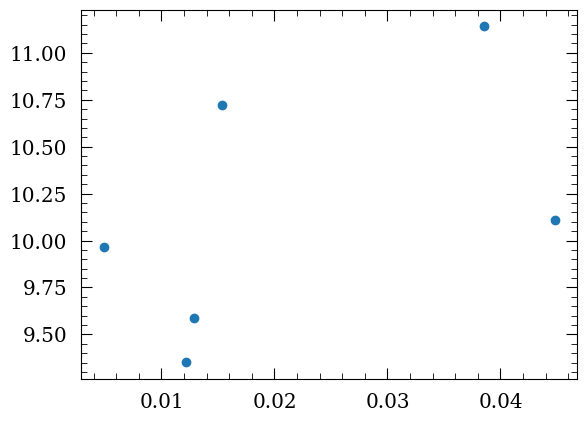

|---------------------------|
 Run-time:  33.0527 seconds
|---------------------------|


In [739]:
from pickle import FALSE
""" MAIN """
if __name__ == '__main__':
    start = systime.time() # Runtime tracker

    recover_dir() # Recovering vital directories

    # burns_cspvdr3(fit_filters=None, skip_problems=False, use_saved=False, snpy_plots=False)
    # burns_plotting([]) # Options: ['reg_hist', 'res_hist', 'zvmu']

    # atlas_collection(quiet=False, check_data=True)
    # atlas_objs = atlas_processing(err_max=1000, n_iter=0, sleep_t=10, use_TNS=True)
    # atlas_write_ASCII(atlas_objs, save_loc=SNPY_ATLAS_ASCII, quiet=False)
    # atlas_snpy_fitting(n_iter=0, skip_problems=False, use_saved=False, snpy_plots=False)
    # atlas_plotting(['reg_hist'])

    # ztf_collection(submit=True)
    # ztf_alt_collection()

    z, logstellarmass = ghost_host_galaxy(BURNS_SAVE_TXT, save_loc=TEST_ROOT, keep_data=False, update_saved=True)
    plt.scatter(z, logstellarmass)
    plt.show()




    print('|---------------------------|\n Run-time: ', round(systime.time()-start, 4), 'seconds\n|---------------------------|')